In [1]:
from matplotlib import pyplot as plt
from typing import Tuple, Any
import cv2
import random
import numpy as np
import pandas as pd
import os
import torch.nn as nn
from PIL import Image
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

In [2]:
csv = "D:/python/annotation_dataset.csv"
data = pd.read_csv(csv,  usecols=[0, 2])
(data)

,absolute_path,class
0,D:\python\dataset\leopard\0000.jpg,leopard
1,D:\python\dataset\leopard\0001.jpg,leopard
2,D:\python\dataset\leopard\0002.jpg,leopard
3,D:\python\dataset\leopard\0003.jpg,leopard
4,D:\python\dataset\leopard\0004.jpg,leopard
...,...,...
2035,D:\python\dataset\tiger\1015.jpg,tiger
2036,D:\python\dataset\tiger\1016.jpg,tiger
2037,D:\python\dataset\tiger\1017.jpg,tiger
2038,D:\python\dataset\tiger\1018.jpg,tiger


In [3]:
names = set(data["class"].to_list())

In [4]:
splited_by_class, train_list, test_list, val_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
i = 0
for name in names:
    splited_by_class = data.loc[data['class'] == name]
    train_list = pd.concat([train_list, splited_by_class[0 : int(len(splited_by_class) * 0.8)]], )
    test_list = pd.concat([test_list, splited_by_class[int(len(splited_by_class) * 0.8) : int(len(splited_by_class) * 0.9)]], ignore_index = True)
    val_list = pd.concat([val_list, splited_by_class[int(len(splited_by_class) * 0.9) : int(len(splited_by_class))]], ignore_index = True)
    i+=1

Проверка на сбалансированность

In [5]:
train_stats = train_list['class'].value_counts()
test_stats = train_list['class'].value_counts()
val_stats = train_list['class'].value_counts()
if not train_stats.min() / train_stats.max() >= 0.98:
    print("not ok")
elif not test_stats.min() / test_stats.max() >= 0.98:
    print("not ok")
elif not val_stats.min() / val_stats.max() >= 0.98:
    print("not ok")
else:
    print("ok")

ok


Класс для хранения картинок

In [17]:
class CustomDataset(torch.utils.data.Dataset):
  """Class to store images"""
  def __init__(self, images, transform:Any=None) -> None:
        self.dataset = images
        self.transform = transform

  def __len__(self) -> int:
    return len(self.dataset)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset.iloc[index, 0]
    image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
    image = self.transform(image)
    label = self.dataset.iloc[index, 1]

    if label == "tiger":
       label = 0
    elif label == "leopard":
       label = 1

    return image, label

Предобработка

In [7]:
train_list.iloc[0]

absolute_path    D:\python\dataset\tiger\0000.jpg
class                                       tiger
Name: 1020, dtype: object

In [18]:
custom_transforms = transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Resize((224, 224)),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
)
train_data = CustomDataset(train_list, transform=custom_transforms)
test_data = CustomDataset(test_list, transform=custom_transforms)
val_data = CustomDataset(val_list, transform=custom_transforms)
val_data.__getitem__(0)

(tensor([[[0.7607, 0.7455, 0.7292,  ..., 0.9474, 0.9613, 0.9772],
          [0.9291, 0.9291, 0.9272,  ..., 0.9474, 0.9613, 0.9646],
          [0.8630, 0.8630, 0.8680,  ..., 0.9421, 0.9474, 0.9635],
          ...,
          [2.0020, 1.9795, 1.9406,  ..., 2.0764, 2.0764, 2.0764],
          [2.0443, 2.0353, 2.0180,  ..., 2.0838, 2.0838, 2.0838],
          [2.1161, 2.0817, 2.0569,  ..., 2.0813, 2.0813, 2.0813]],
 
         [[0.9946, 0.9792, 0.9625,  ..., 1.1856, 1.1998, 1.2160],
          [1.1668, 1.1668, 1.1649,  ..., 1.1856, 1.1998, 1.2031],
          [1.0993, 1.0993, 1.1044,  ..., 1.1801, 1.1856, 1.2020],
          ...,
          [2.3337, 2.3107, 2.2709,  ..., 2.2698, 2.2698, 2.2698],
          [2.3769, 2.3678, 2.3500,  ..., 2.2648, 2.2648, 2.2648],
          [2.4246, 2.4152, 2.3898,  ..., 2.2397, 2.2397, 2.2397]],
 
         [[1.5436, 1.5282, 1.5116,  ..., 1.7511, 1.7653, 1.7814],
          [1.7150, 1.7150, 1.7131,  ..., 1.7511, 1.7653, 1.7685],
          [1.6478, 1.6478, 1.6528,  ...,

In [19]:
train_data[0][0].shape

torch.Size([3, 224, 224])

Модель свёрточной нейросети

In [20]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(576, 10)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return torch.nn.Sigmoid()(output)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = CNN()
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

Графики

In [22]:
def chart(epochs, train_acc, train_loss, valid_acc, valid_loss) -> None:
    """Creates graphs based on the learning results"""
    fig=plt.figure(figsize=(20, 10))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Neural network training results')
    plt.plot(range(epochs), train_acc, color='green', linestyle='-', linewidth=1, label='Train accuracy') 
    plt.plot(range(epochs) ,train_loss, color='red', linestyle='--', linewidth=1, label='Train loss')
    plt.legend() 
    plt.show()

    fig=plt.figure(figsize=(20, 10))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Neural network training results')
    plt.plot(range(epochs), valid_acc, color='green', linestyle='-', linewidth=1, label='Validation accuracy') 
    plt.plot(range(epochs) ,valid_loss, color='red', linestyle='--', linewidth=1, label='Validation loss')
    plt.legend() 
    plt.show()

In [27]:
def train_loop(epochs, batch_size, lear) -> Tuple[list, CNN]:
    optimizer = optim.Adam(params=model.parameters(), lr=lear)
    criterion = nn.BCELoss(reduction='sum')
    train_accuracy_values = []
    train_loss_values = []

    val_accuracy_values = []
    val_loss_values = []
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data, batch_size=batch_size, shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset=val_data, batch_size=batch_size, shuffle=False
    )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        for data, label in train_loader: # 400
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()

            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracy_values.append(epoch_accuracy)
        train_loss_values.append(epoch_loss)
    print(f'Epoch : {epoch + 1}, train accuracy : {epoch_accuracy}, train loss : {epoch_loss}')

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += loss / len(valid_loader)

        val_accuracy_values.append(epoch_val_accuracy)
        val_loss_values.append(epoch_val_loss)

    print(f"Epoch : {epoch + 1}, val_accuracy : {epoch_val_accuracy}, val_loss : {epoch_val_loss}")
    chart(epochs, train_accuracy_values, train_loss_values, val_accuracy_values, val_loss_values)

Обучение.

Epoch : 10, train accuracy : 0.5024999976158142, train loss : 24.829111099243164
Epoch : 10, val_accuracy : 3.666666666666666, val_loss : 31.42137908935547


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

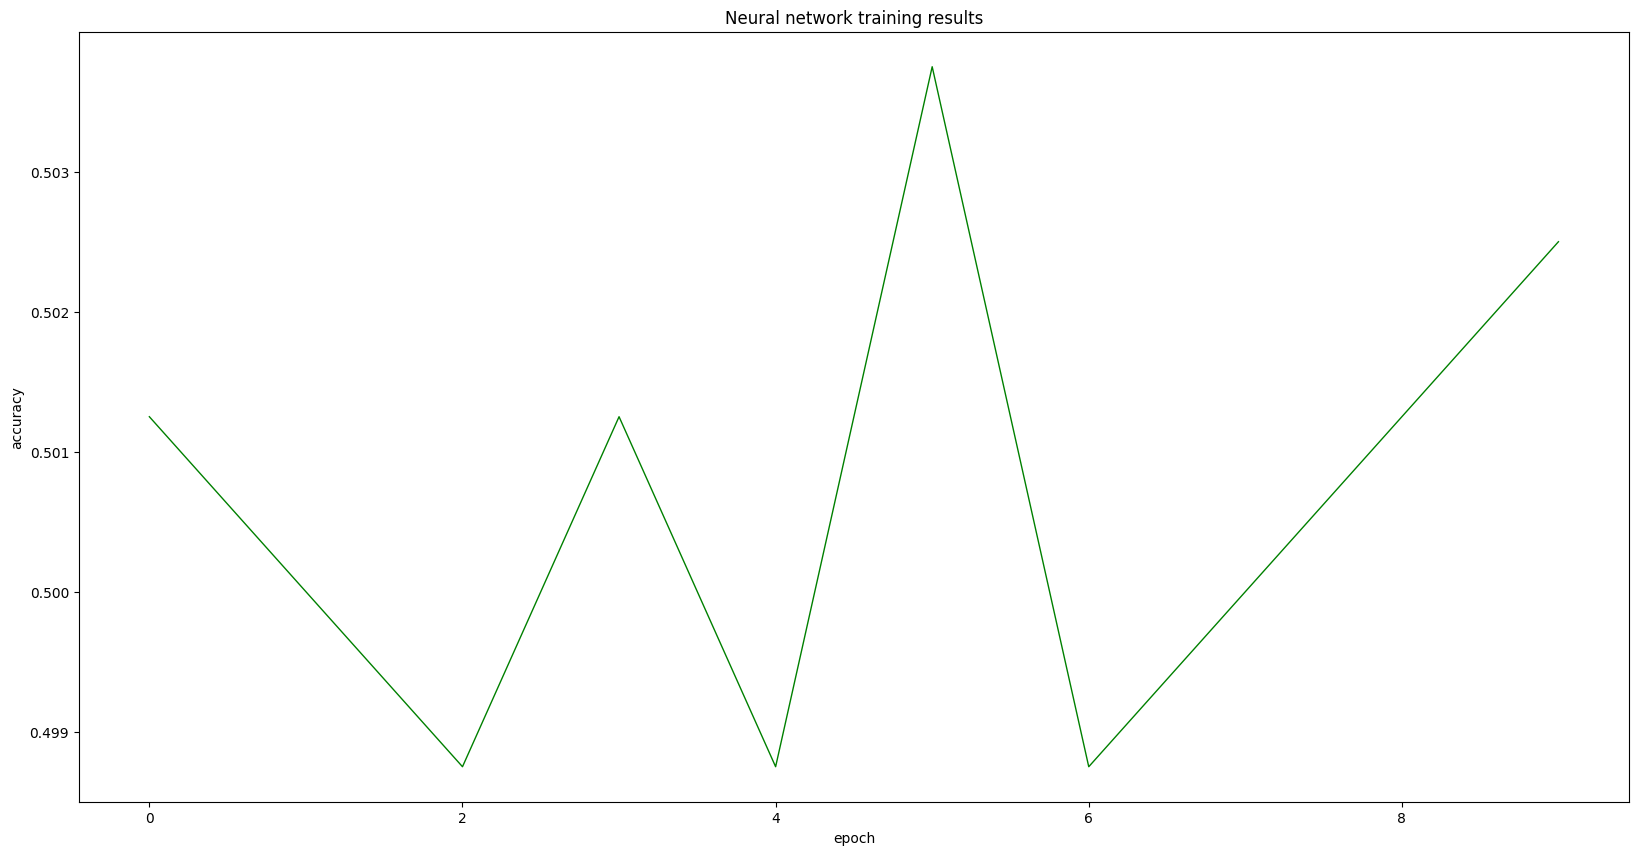

In [26]:
train_loop(10, 100, 0.001)